In [43]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, TweetTokenizer 
  
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import string
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, ConfusionMatrixDisplay, confusion_matrix, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

# Notice that these vectorizers are from `sklearn` and not `nltk`!
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,HashingVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import nltk
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /Users/jayiraj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/jayiraj/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jayiraj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [44]:
df= pd.read_csv('../data/judge-1377884607_tweet_product_company.csv', encoding='latin1')

In [45]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [46]:
# Rename the columns
df = df.rename(columns={
    'emotion_in_tweet_is_directed_at': 'products',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotions'
})

df.head()

,tweet_text,products,emotions
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [47]:
df['emotions'] = df['emotions'].replace('No emotion toward brand or product', 'Neutral')
df['emotions'] = df['emotions'].replace('Positive emotion', 'Positive')
df['emotions'] = df['emotions'].replace('Negative emotion', 'Negative')

In [48]:
df = df[df['emotions'].isin(['Neutral', 'Negative', 'Positive'])]

In [49]:
df['emotions'].value_counts()

Neutral     5389
Positive    2978
Negative     570
Name: emotions, dtype: int64

In [26]:
#Map emotions to target values
#label_encoder = LabelEncoder()

# Fitting the encoder to the 'emotions' column and transforming it
#df['target'] = label_encoder.fit_transform(df['emotions'])

# Checking the first few rows to see the result
#df.head()


In [50]:
df['emotions'].value_counts()

Neutral     5389
Positive    2978
Negative     570
Name: emotions, dtype: int64

In [51]:
df.isna().sum()

tweet_text       1
products      5655
emotions         0
dtype: int64

In [52]:
df = df.dropna(subset=['tweet_text'])

In [53]:
df.isna().sum()

tweet_text       0
products      5654
emotions         0
dtype: int64

In [54]:
# Bring in stopwords

sw = stopwords.words('english')

In [55]:
# Add custom words to the stopword list
custom_stopwords = ['sxsw', 'mention','link','rt', 'for','quot']

# Extend the NLTK stopword list with custom stopwords
sw.extend(custom_stopwords)

In [56]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [57]:
lemmatizer = WordNetLemmatizer() 

In [58]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: column from database
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tokens = regex_token.tokenize(doc)
    lowered_t = [word.lower() for word in tokens]
    no_sw_t = [word for word in lowered_t if word not in sw]
    # print(doc)
    tokens_tagged = pos_tag(no_sw_t)
    pos_tokens = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged] 
    tokens_lemm = [lemmatizer.lemmatize(word[0], word[1]) for word in pos_tokens]
    return ' '.join(tokens_lemm)

In [59]:
# Create a new column in your DataFrame for the preprocessed text
df['preprocessed_text'] = df['tweet_text'].apply(lambda x: doc_preparer(x))

# Now you can perform EDA on 'preprocessed_text'
# For example, token frequency analysis
from collections import Counter
all_words = ' '.join(df['preprocessed_text']).split()
word_freq = Counter(all_words)
word_freq

Counter({'wesley': 1,
         'g': 79,
         'iphone': 1560,
         'hr': 5,
         'tweet': 169,
         'rise': 12,
         'austin': 959,
         'dead': 18,
         'need': 240,
         'upgrade': 15,
         'plugin': 4,
         'station': 12,
         'jessedee': 1,
         'know': 208,
         'fludapp': 1,
         'awesome': 135,
         'ipad': 2961,
         'app': 821,
         'likely': 13,
         'appreciate': 6,
         'design': 225,
         'also': 77,
         'give': 185,
         'free': 390,
         't': 2,
         'swonderlin': 1,
         'wait': 137,
         'sale': 46,
         'hope': 51,
         'year': 167,
         'festival': 32,
         'crashy': 2,
         'sxtxstate': 9,
         'great': 226,
         'stuff': 35,
         'fri': 7,
         'marissa': 193,
         'mayer': 219,
         'google': 2621,
         'tim': 19,
         'reilly': 9,
         'tech': 166,
         'book': 39,
         'conference': 71,
         '

In [60]:
all_words = ' '.join(df['preprocessed_text']).split()

# Compute the frequency distribution
freq_dist = FreqDist(all_words)

# Display the most common words
print(freq_dist.most_common(50))

[('ipad', 2961), ('google', 2621), ('apple', 2309), ('iphone', 1560), ('store', 1508), ('new', 1086), ('austin', 959), ('amp', 834), ('app', 821), ('launch', 817), ('get', 693), ('circle', 673), ('social', 658), ('pop', 601), ('android', 594), ('today', 576), ('open', 520), ('go', 477), ('network', 473), ('line', 452), ('via', 428), ('party', 401), ('call', 395), ('free', 390), ('mobile', 357), ('come', 347), ('sxswi', 340), ('win', 313), ('one', 313), ('time', 309), ('see', 308), ('check', 305), ('like', 303), ('major', 303), ('use', 291), ('day', 288), ('make', 285), ('map', 273), ('w', 269), ('u', 266), ('temporary', 264), ('need', 240), ('possibly', 240), ('look', 233), ('great', 226), ('people', 226), ('design', 225), ('downtown', 225), ('apps', 223), ('mayer', 219)]


# Splitting our Data

In [61]:
X = df['tweet_text'] 
y = df['emotions'] 

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Creating Pipelines

In [95]:

#Multinomial Naive Bayes Pipeline
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=doc_preparer)),
    ('nb', MultinomialNB())
])

In [64]:
#Random Forest Pipeline
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=doc_preparer)),
    ('rf', RandomForestClassifier(random_state = 42, class_weight='balanced'))
])

# Grid Search Set Up

In [65]:
nb_param_grid = {
    'tfidf__max_df': [0.75],
    'tfidf__min_df': [.01,.05,.1],
    'tfidf__ngram_range': [(1, 2)],
}

In [66]:
rf_param_grid = {
    'tfidf__max_df': [0.5, .6],
    'tfidf__min_df': [1, 10, 20],
    'tfidf__ngram_range': [(1, 1)],
    'rf__n_estimators': [200, 500], 
    'rf__max_depth': [10, 20, 30, None],}

# Naive Bayes Grid Search

In [174]:
# Calculate class weights
class_weights = compute_sample_weight('balanced', y_train)
# Ensure class_weights has the correct length
class_weights = class_weights[:X_train.shape[0]]

In [34]:
nb_grid_search = GridSearchCV(nb_pipeline, nb_param_grid, cv=3, n_jobs=1, verbose=2)
nb_grid_search.fit(X_train, y_train) 

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


PicklingError: Could not pickle the task to send it to the workers.

# Random Forest Grid Search

In [67]:
# Grid search with RandomForestClassifier pipeline
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, n_jobs=1, verbose=2)
rf_grid_search.fit(X_train, y_train) 

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] rf__max_depth=10, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rf__max_depth=10, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.2s
[CV] rf__max_depth=10, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV]  rf__max_depth=10, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.2s
[CV] rf__max_depth=10, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.2s
[CV] rf__max_depth=10, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.2s
[CV] rf__max_depth=10, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.2s
[CV] rf__max_depth=10, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=10, rf__n_estimators=200, tfidf__max_df=0.5, tfidf_

[CV]  rf__max_depth=20, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.6s
[CV] rf__max_depth=20, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   3.6s
[CV] rf__max_depth=20, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.5s
[CV] rf__max_depth=20, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.5s
[CV] rf__max_depth=20, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=20, rf__n_estimators=200, tfidf__max_df=0.5, tfidf_

[CV]  rf__max_depth=30, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=30, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.2s
[CV] rf__max_depth=30, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.8s
[CV] rf__max_depth=30, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   3.9s
[CV] rf__max_depth=30, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=30, rf__n_estimators=200, tfidf__max_df=0.5, tfidf_

[CV]  rf__max_depth=None, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   9.3s
[CV] rf__max_depth=None, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   9.0s
[CV] rf__max_depth=None, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   5.9s
[CV] rf__max_depth=None, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1), total=   6.1s
[CV] rf__max_depth=None, rf__n_estimators=200, tfidf__max_df=0.5, tfidf__min_df=10, tfidf__ngram_range=(1, 1) 
[CV]  rf__max_depth=None, rf__n_estimators=200, tfidf__

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 13.5min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function doc_preparer at 0x7fc339269940>)),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=1,
             param_grid={'rf__max_depth': [10, 20, 30, None],
                         'rf__n_estimators': [200, 500],
                         'tfidf__max_df': [0.5, 0.6],
                         'tfidf__min_df': [1, 10, 20],
                         'tfidf__ngram_range': [(1, 1)]},
             verbose=2)

# Model Evaluation

In [177]:
# Evaluation for Naive Bayes


nb_best_model = nb_grid_search.best_estimator_
print("Best Parameters for Naive Bayes:", nb_grid_search.best_params_)
print("Grid Search Best Score:", nb_grid_search.best_score_)
#print(classification_report(y_test, y_pred_nb))


Best Parameters for Naive Bayes: {'tfidf__max_df': 0.75, 'tfidf__min_df': 0.01, 'tfidf__ngram_range': (1, 2)}
Grid Search Best Score: 0.6439556245014607


In [69]:
#Evaluation for Random Forest
rf_best_model = rf_grid_search.best_estimator_
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)
print("Grid Search Best Score:", rf_grid_search.best_score_)



#print(classification_report(y_test, y_pred_rf))

Best Parameters for Random Forest: {'rf__max_depth': None, 'rf__n_estimators': 500, 'tfidf__max_df': 0.5, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Grid Search Best Score: 0.6733349118246973


In [70]:
rf_best_model.score(X_train, y_train)

0.95747062115277

# Confusion Matrix

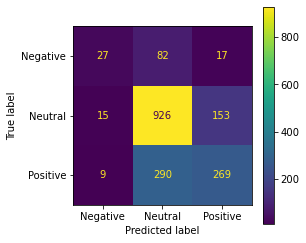

In [72]:
y_pred_rf = rf_best_model.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
# Plot the Confusion Matrix with a smaller size
fig, ax = plt.subplots(figsize=(4, 4))  
ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels= rf_best_model.classes_).plot(ax=ax)

# Show the plot
plt.show()

## Features importances

In [84]:
tfidf_vectorizer = rf_best_model.named_steps['tfidf']
feature_names = tfidf_vectorizer.get_feature_names()
rf_feature_names = tfidf_vectorizer.get_feature_names()
#rf_tfidf_scores = tfidf_vectorizer.idf_

In [85]:
rf_model = rf_best_model.named_steps['rf']
rf_feature_importances = rf_model.feature_importances_

In [86]:
#rf_tfidf_feature_importance = dict(zip(rf_feature_names, rf_tfidf_scores))
#sorted_rf_tfidf_importance = sorted(rf_tfidf_feature_importance.items(), key=lambda x: x[1], reverse=True)

# For Random Forest
rf_feature_importance = dict(zip(rf_feature_names, rf_feature_importances))
sorted_rf_importance = sorted(rf_feature_importance.items(), key=lambda x: x[1], reverse=True)

print("Random Forest Feature Importance:", sorted_rf_importance[:50])

Random Forest Feature Importance: [('ipad', 0.01777161677688932), ('apple', 0.013383589810890328), ('google', 0.011678824004508566), ('iphone', 0.011152378583625314), ('store', 0.010069260100078373), ('app', 0.007814092140371326), ('new', 0.006720447016068586), ('austin', 0.006634270379195681), ('amp', 0.006202715807359744), ('launch', 0.00556525074858539), ('get', 0.005504069638783623), ('pop', 0.005236557197767293), ('like', 0.005120045998355096), ('cool', 0.005065424662863726), ('headache', 0.004967079700154656), ('people', 0.004829108825937766), ('great', 0.00465310139198606), ('line', 0.004508654393636384), ('fail', 0.004502826613722335), ('circle', 0.0044328197888252535), ('social', 0.004353639215892607), ('android', 0.004340674225496847), ('today', 0.004241816920628351), ('open', 0.0041628674394218555), ('win', 0.003993796394465651), ('go', 0.0039394342012385765), ('via', 0.003832926817392188), ('suck', 0.0037933710076904084), ('party', 0.0037419302501019596), ('free', 0.0037082

In [ ]:
#pd.DataFrame.sparse.from_spmatrix(X_t_vec, columns=tfidf.get_feature_names_out())

In [88]:
rf_feature_importances

array([1.62217071e-04, 8.93242200e-06, 2.14003761e-05, ...,
       8.34290010e-06, 2.14696135e-05, 4.81383770e-05])

# Model Evaluation on the Test Set

In [ ]:
X_val


X_val_df = pd.DataFrame(X_val_vec.toarray(), columns=tfidf.get_feature_names_out())
final_X_test = pd.concat([
    X_val_df, X_t[["num_sentences", "contains_price", "contains_emoticon"]]
], axis=1)
final_X_test